# Student Attention Analysis using Live web-cam video feed



This project is implemented to provide a non-invasive attention monitoring system for educators to better tailor their teaching approach towards the target audience ie the students

Here I have used three main sub systems as follows:

* A pose recognition system to check if the student is distracted and turning his head sideways
* An emotion recongntiion model which will monitor the emotion of the students through the session
* An eye-tracking model which will be used to check if the user's eye is focused on the screen at all times. This can be used to prevent malpractices during the session



#Installing needed pre requisites for the implementation


*   Mediapipe is a library which uses haar cascade xml files to landmark facial features in the video feed 
*   Pygal is used here for analyzing the data received fromt he video feed
*   The Gaze Tracking repository is a part of an open source eye-tracking software developed by Mr Antonie Lame, used here in accordance with MIT Licensed open source project regulations





In [1]:
!pip install mediapipe
!pip instlal pygal
!git clone https://github.com/antoinelame/GazeTracking.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 32.9 MB 1.3 MB/s 
ERROR: unknown command "instlal" - maybe you meant "install"
Cloning into 'GazeTracking'...
remote: Enumerating objects: 113, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 113 (delta 6), reused 11 (delta 0), pack-reused 89
Receiving objects: 100% (113/113), 69.01 MiB | 24.85 MiB/s, done.
Resolving deltas: 100% (49/49), done.


###Importing all the necessary libraries

In [ ]:
import cv2
from pandas import ExcelFile
import pygal
import time
import numpy as np
import mediapipe as mp
import tensorflow as tf
from GazeTracking.gaze_tracking import GazeTracking
from matplotlib import pyplot as plt


from tensorflow import keras
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau, TensorBoard, EarlyStopping, ModelCheckpoint
from keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop

###Getting the emotion analysis model using a CNN with four convolution layers following a flatten and a dense fully connected layers. 

We will be using FER 2013 dataset for emotion recognition. We use a flo_from_directory function to take this input in and train the convolutional net with it 

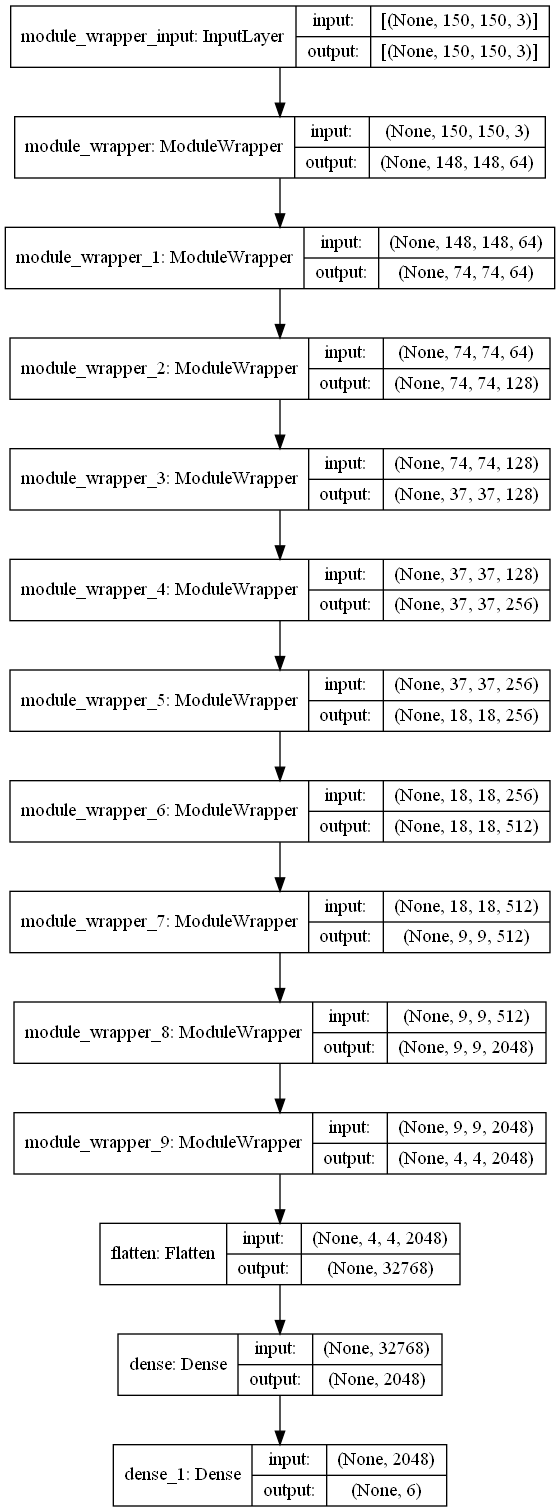

In [ ]:

num_features = 32
num_labels = 6
width, height = 150, 150
batch_size = 64
epochs = 1#10
train_steps_per_epoch = 10#400
validation_steps_per_epoch = 2#100


def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  train_datagen = ImageDataGenerator(rescale=1 / 255)

  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      class_mode='categorical',
                                                      target_size=(width, height))

  validation_datagen = ImageDataGenerator(rescale=1 / 255)

  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                class_mode='categorical',
                                                                target_size=(width, height))
  x_train, y_train = next(train_generator)
  shape_x = x_train.shape
  shape_y = y_train.shape
  return train_generator, validation_generator, shape_x, shape_y

def create_model():

    model = Sequential()

    model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', input_shape=(width, height, 3),data_format='channels_last', kernel_regularizer=l2(0.01)))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Conv2D(2 * num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Conv2D(2 * 2 * num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Conv2D(2 * 2 * 2 * num_features, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Flatten())

    model.add(Dense(2 * 2 * 2 * 2 * num_features, activation='relu',input_shape=(None,1)))
    model.add(Dense(num_labels, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['acc'])

    return model





TRAINING_DIR = "dataset/train"
TESTING_DIR = "dataset/test"
train_generator, test_generator, shape_x, shape_y= train_val_generators(TRAINING_DIR, TESTING_DIR)

print(shape_x)
print(shape_y)

model = create_model()

model.build((None,width,height,3))

model.summary()


model.fit(train_generator,
                validation_steps=validation_steps_per_epoch,
                steps_per_epoch = train_steps_per_epoch,
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                validation_data=test_generator,
                shuffle=True)

    



TRAINING_DIR = "C:/Users/csara/Dev and College/Dev/Student attention detection/dataset/train"
TESTING_DIR = "C:/Users/csara/Dev and College/Dev/Student attention detection/dataset/test"
train_generator, test_generator, shape_x, shape_y= train_val_generators(TRAINING_DIR, TESTING_DIR)

print(shape_x)
print(shape_y)

model = create_model()

model.build((None,width,height,3))
tf.keras.utils.plot_model(
    model,
    to_file='emotion_analysis_architecture.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=96,
)
model.summary()

model.fit(train_generator,
                validation_steps=validation_steps_per_epoch,
                steps_per_epoch = train_steps_per_epoch,
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                validation_data=test_generator,
                shuffle=True)

model.save('emotion_analysis')
print("Saved model to disk")

Before the main function, we initialize some variables and list and a reference dictionary

In [ ]:
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5)
mp_drawing = mp.solutions.drawing_utils
drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)
emotion_dict = {0: "Angry", 1: "Happy", 2: "Neutral", 3: "Sad", 4: "Surprised", 5:"Sleepy", 6:"Away from screen"}

count_attention = [0,0,0,0,0,0,0]
count_emotion = [0,0,0,0,0,0]
emotion_list = []
pose_list = []
eyetrack_list = []
attention_list = []


model = tf.keras.models.load_model('./saved_models')
facecasc = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

gaze = GazeTracking()


### Now that we have got the deep learning model saved to the disk, we go on to build the main function for getting the input video feed and analyzing it

In [ ]:

cap = cv2.VideoCapture(0)



while cap.isOpened():
    success, img = cap.read()

    start = time.time()

    # Flip the img horizontally for a later selfie-view display
    # Also convert the color space from BGR to RGB
    img = cv2.cvtColor(cv2.flip(img, 1), cv2.COLOR_BGR2RGB)
    faces = facecasc.detectMultiScale(img, scaleFactor=1.3, minNeighbors=5)

    # To improve performance
    img.flags.writeable = False
    
    # Get the result
    results = face_mesh.process(img)
    
    # To improve performance
    img.flags.writeable = True
    
    # Convert the color space from RGB to BGR
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    img_h, img_w, img_c = img.shape
    face_3d = []
    face_2d = []

    #gaze tracking
    gaze.refresh(img)

    img = gaze.annotated_frame()
    text = ""

    if gaze.is_right() or gaze.is_left():
        text = "Eyes not focused"
        eyetrack_list.append(0)
    elif gaze.is_blinking():
        emotion_list.append(5)
    else:
        text = "Eyes focused on the screen"
        eyetrack_list.append(1)

    cv2.putText(img, text, (20, 100), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 0, 0), 2)

    #emotion recognition

    for (x, y, w, h) in faces:
        cv2.rectangle(img, (x, y - 50), (x + w, y + h + 10), (255, 0, 0), 2)
        roi = img[y:y + h, x:x + w]
        cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi, (150, 150)), -1), 0)
        prediction = model.predict(cropped_img)
        index = int(np.argmax(prediction))
        emotion_list.append(index)
        count_emotion[index] += 1
        cv2.putText(img, emotion_dict[index], (x + 20, y - 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2,
                    cv2.LINE_AA)


    if not results.multi_face_landmarks:
        cv2.putText(img, "Face not available", (20, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        count_attention[6]+=1
    else:
        for face_landmarks in results.multi_face_landmarks:
            for idx, lm in enumerate(face_landmarks.landmark):
                if idx == 33 or idx == 263 or idx == 1 or idx == 61 or idx == 291 or idx == 199:
                    if idx == 1:
                        nose_2d = (lm.x * img_w, lm.y * img_h)
                        nose_3d = (lm.x * img_w, lm.y * img_h, lm.z * 3000)

                    x, y = int(lm.x * img_w), int(lm.y * img_h)

                    # Get the 2D Coordinates
                    face_2d.append([x, y])

                    # Get the 3D Coordinates
                    face_3d.append([x, y, lm.z])       
            
            # Convert it to the NumPy array
            face_2d = np.array(face_2d, dtype=np.float64)

            # Convert it to the NumPy array
            face_3d = np.array(face_3d, dtype=np.float64)

            # The camera matrix
            focal_length = 1 * img_w

            cam_matrix = np.array([ [focal_length, 0, img_h / 2],
                                    [0, focal_length, img_w / 2],
                                    [0, 0, 1]])

            # The distortion parameters
            dist_matrix = np.zeros((4, 1), dtype=np.float64)

            # Solve PnP
            success, rot_vec, trans_vec = cv2.solvePnP(face_3d, face_2d, cam_matrix, dist_matrix)

            # Get rotational matrix
            rmat, jac = cv2.Rodrigues(rot_vec)

            # Get angles
            angles, mtxR, mtxQ, Qx, Qy, Qz = cv2.RQDecomp3x3(rmat)

            # Get the y rotation degree
            x = angles[0] * 360
            y = angles[1] * 360
            z = angles[2] * 360
          

            # See where the user's head tilting
            if y < -10:
                text = "Head at Left"
                stat = 0
            elif y > 10:
                text = "Head at Right"
                stat = 0
            elif x < -10:
                text = "Head Down"
                stat = 2
            elif x > 10:
                text = "Head Up"
                stat = 0
            else:
                text = "Head straight"
                stat = 1

            pose_list.append(stat)

            # Display the nose direction
            nose_3d_projection, jacobian = cv2.projectPoints(nose_3d, rot_vec, trans_vec, cam_matrix, dist_matrix)

            p1 = (int(nose_2d[0]), int(nose_2d[1]))
            p2 = (int(nose_2d[0] + y * 10) , int(nose_2d[1] - x * 10))
            
            cv2.line(img, p1, p2, (255, 0, 0), 3)

            # Add the text on the img
            cv2.putText(img, text, (20, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            cv2.putText(img, "x: " + str(np.round(x,2)), (500, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
            cv2.putText(img, "y: " + str(np.round(y,2)), (500, 100), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
            cv2.putText(img, "z: " + str(np.round(z,2)), (500, 150), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)


        end = time.time()
        totalTime = end - start

        fps = 1 / totalTime
        #print("FPS: ", fps)

        cv2.putText(img, f'FPS: {int(fps)}', (20,450), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)

        mp_drawing.draw_landmarks(
                    image=img,
                    landmark_list=face_landmarks,
                    connections=mp_face_mesh.FACEMESH_CONTOURS,
                    landmark_drawing_spec=drawing_spec,
                    connection_drawing_spec=drawing_spec)



    cv2.imshow('Attention Analysis', img)

    if cv2.waitKey(1) & 0xFF == 27:
        break


cap.release()


### Now we code a small snippet for the data analytics we got from teh video feed

In [ ]:
for i in range (len(emotion_list)):

    if pose_list[i] == 0:
        attention_list.append(6)
        count_attention[5]+=1
    elif pose_list[i] == 2:
        attention_list.append(4)
        count_attention[3]+=1
    else:
        if eyetrack_list[i] == 0:
            attention_list.append(5)
            count_attention[4] += 1
        else:
            if emotion_list[i] == 0 and emotion_list[i] == 2 and emotion_list[i] == 3:
                attention_list.append(3)
                count_attention[2] += 1
            elif emotion_list[i] == 2:
                attention_list.append(2)
                count_attention[1] += 1
            elif emotion_list[i] == 1:
                attention_list.append(1)
                count_attention[0] += 1
            elif emotion_list[i] == 5:
                attention_list.append(7)
                count_attention[0] += 1




horizontal_chart = pygal.HorizontalBar()
horizontal_chart.title = 'Student Attention Analytics'
horizontal_chart.add('Attentive and Happy (Level 1)', count_attention[0])
horizontal_chart.add('Attentive and Surprised (Level 2)', count_attention[1])
horizontal_chart.add('Attentive and Neutral (Level3)', count_attention[2])
horizontal_chart.add('Writing (Level 4)', count_attention[3])
horizontal_chart.add('Eye away from screen (Level 5)', count_attention[4])
horizontal_chart.add('Sleepy / Tired / Bored (Level 6)', count_attention[7])
horizontal_chart.add('Totally distracted (Level 7)', count_attention[5])
horizontal_chart.add('Face away from the screen (Level 8)', count_attention[6])
horizontal_chart.render_to_file('attention_analytics.svg')
print("attention analytics saved")



pie_chart = pygal.Pie()
pie_chart.title = 'Radar chart'
pie_chart.add('Angry', count_emotion[0])
pie_chart.add('Happy', count_emotion[1])
pie_chart.add('Neutral', count_emotion[2])
pie_chart.add('Sad', count_emotion[3])
pie_chart.add('Surprised', count_emotion[4])
pie_chart.add('Sleepy / Tired / Bored', count_emotion[5])
pie_chart.render_to_file('emotion_analytics.svg')
print("emotion analytics saved")


### Thats the end of the project. Now the analytics for the video feed are saved as .svg fiels in the parent project directory